In [1]:
# --- 📚 Import Libraries ---

import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# --- ⚙️ Configuration ---

TRAIN_DATA_PATH = "/Users/anuragde/Documents/project-work/finalsubmission/preprocessed_data/mydata_spectrograms.npy"
TRAIN_LABELS_PATH = "/Users/anuragde/Documents/project-work/finalsubmission/preprocessed_data/mydata_labels.npy"
VAL_DATA_PATH = "/Users/anuragde/Documents/project-work/finalsubmission/preprocessed_val_data/myvaldata_spectrograms.npy"
VAL_LABELS_PATH = "/Users/anuragde/Documents/project-work/finalsubmission/preprocessed_val_data/myvaldata_labels.npy"
MODEL_SAVE_PATH = "myfullmodel/best_model.pth"
EPOCHS = 50
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
EARLY_STOPPING_PATIENCE = 5

In [3]:
# ---  🎛️ Helper Functions, Dataset, and Model Classes ---

def evaluate_model(model, data_loader, device):
    """Evaluate model accuracy on a data loader"""
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for spectrograms, labels in data_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            spectrograms = spectrograms.unsqueeze(1)
            
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

class SpectrogramDataset(Dataset):
    """Custom PyTorch Dataset for loading spectrogram NumPy arrays."""
    def __init__(self, spectrograms, labels):
        self.spectrograms = torch.from_numpy(spectrograms)
        self.labels = torch.from_numpy(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

class SignalCNN2D(nn.Module):
    """A 2D Convolutional Neural Network for spectrogram classification."""
    def __init__(self, input_shape):
        super(SignalCNN2D, self).__init__()
        c, h, w = input_shape
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        
        flattened_size = self._get_conv_output_size(input_shape)
        
        self.fc_block = nn.Sequential(
            nn.Linear(flattened_size, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 2))

    def _get_conv_output_size(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.conv_block1(x)
            x = self.conv_block2(x)
            return x.numel()

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x

In [4]:
# --- 🧠 Training Script ---

# --- Set compute device ---
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"--- Using device: {device} ---")

# --- Load Data ---
print("\n--- Loading Data ---")
train_spectrograms = np.load(TRAIN_DATA_PATH)
train_labels = np.load(TRAIN_LABELS_PATH)
val_spectrograms = np.load(VAL_DATA_PATH)
val_labels = np.load(VAL_LABELS_PATH)

H, W = train_spectrograms.shape[1], train_spectrograms.shape[2]
input_shape_for_model = (1, H, W)
print(f"Input shape for model (C, H, W): {input_shape_for_model}")

# --- Create DataLoaders ---
print("\n--- Creating DataLoaders ---")
train_dataset = SpectrogramDataset(train_spectrograms, train_labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = SpectrogramDataset(val_spectrograms, val_labels)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Class Weights ---
print("\n--- Calculating Class Weights ---")
class_counts = pd.Series(train_labels).value_counts().sort_index()
class_weights = None
if len(class_counts) == 2:
    weight_for_0 = len(train_labels) / (2 * class_counts[0])
    weight_for_1 = len(train_labels) / (2 * class_counts[1])
    class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float32).to(device)
    print(f"Calculated weights: {class_weights.cpu().numpy()}")

# --- Initialize Model, Loss, and Optimizer ---
print("\n--- Initializing Model ---")
cnn_model = SignalCNN2D(input_shape_for_model).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

# --- Ensure the save directory exists ---
os.makedirs("myfullmodel", exist_ok=True)

# --- Main Training Loop ---
print(f"\n--- Starting Training (will stop early if no improvement after {EARLY_STOPPING_PATIENCE} epochs) ---")
training_history = {'train_loss': [], 'val_accuracy': []}
overall_start_time = time.time()

# Variables for early stopping
best_val_accuracy = 0.0
epochs_no_improve = 0
best_model_path = ""

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    # Training phase
    cnn_model.train()
    running_loss = 0.0
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")
    for spectrograms, labels in train_progress_bar:
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        spectrograms = spectrograms.unsqueeze(1)
        outputs = cnn_model(spectrograms)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation phase
    val_accuracy = evaluate_model(cnn_model, val_loader, device)
    training_history['train_loss'].append(avg_train_loss)
    training_history['val_accuracy'].append(val_accuracy)
    
    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} Summary | Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | Duration: {epoch_duration:.2f}s")

    # Checkpointing and Early Stopping Logic
    if val_accuracy > best_val_accuracy:
        print(f"  -> Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}!")
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0

        # If a previous best model exists, delete it
        if os.path.exists(best_model_path):
            os.remove(best_model_path)
            
        # Define a new path and save the current model
        new_best_path = os.path.join("myfullmodel", f"model_epoch_{epoch+1}_acc_{val_accuracy:.4f}.pth")
        torch.save(cnn_model.state_dict(), new_best_path)
        
        # Update the tracker to the new best model path
        best_model_path = new_best_path

    else:
        epochs_no_improve += 1
        print(f"  -> No improvement in validation accuracy for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
            break

overall_end_time = time.time()
total_duration_seconds = overall_end_time - overall_start_time
total_mins = int(total_duration_seconds // 60)
total_secs = int(total_duration_seconds % 60)

print(f"\n--- Training Complete ---")
print(f"Total Training Time: {total_mins} minutes and {total_secs} seconds")

# --- Final Confirmation ---
if best_model_path:
    print(f"\nBest model (Val Acc: {best_val_accuracy:.4f}) is saved at: '{best_model_path}'")
    # Optional: Rename the final best model to a generic name like 'best_model.pth'
    os.rename(best_model_path, MODEL_SAVE_PATH)
    print(f"Final model renamed and saved to: '{MODEL_SAVE_PATH}'")
else:
    print("\nNo improvement found during training. Model not saved.")

--- Using device: mps ---

--- Loading Data ---
Input shape for model (C, H, W): (1, 129, 153)

--- Creating DataLoaders ---

--- Calculating Class Weights ---
Calculated weights: [1. 1.]

--- Initializing Model ---

--- Starting Training (will stop early if no improvement after 5 epochs) ---


Epoch 1/50 [Train]: 100%|██████████| 3750/3750 [02:48<00:00, 22.25batch/s, loss=0.0828]


Epoch 1 Summary | Train Loss: 0.0675 | Val Accuracy: 0.8960 | Duration: 174.66s
  -> Validation accuracy improved from 0.0000 to 0.8960!


Epoch 2/50 [Train]: 100%|██████████| 3750/3750 [02:25<00:00, 25.77batch/s, loss=0.0057]


Epoch 2 Summary | Train Loss: 0.0300 | Val Accuracy: 0.9231 | Duration: 152.99s
  -> Validation accuracy improved from 0.8960 to 0.9231!


Epoch 3/50 [Train]: 100%|██████████| 3750/3750 [02:19<00:00, 26.95batch/s, loss=0.0267]


Epoch 3 Summary | Train Loss: 0.0223 | Val Accuracy: 0.9088 | Duration: 143.20s
  -> No improvement in validation accuracy for 1 epoch(s).


Epoch 4/50 [Train]: 100%|██████████| 3750/3750 [02:22<00:00, 26.23batch/s, loss=0.0066]


Epoch 4 Summary | Train Loss: 0.0180 | Val Accuracy: 0.9369 | Duration: 146.81s
  -> Validation accuracy improved from 0.9231 to 0.9369!


Epoch 5/50 [Train]: 100%|██████████| 3750/3750 [02:18<00:00, 27.13batch/s, loss=0.0198]


Epoch 5 Summary | Train Loss: 0.0156 | Val Accuracy: 0.9286 | Duration: 142.10s
  -> No improvement in validation accuracy for 1 epoch(s).


Epoch 6/50 [Train]: 100%|██████████| 3750/3750 [02:17<00:00, 27.28batch/s, loss=0.0019]


Epoch 6 Summary | Train Loss: 0.0137 | Val Accuracy: 0.9365 | Duration: 141.34s
  -> No improvement in validation accuracy for 2 epoch(s).


Epoch 7/50 [Train]: 100%|██████████| 3750/3750 [02:20<00:00, 26.63batch/s, loss=0.0174]


Epoch 7 Summary | Train Loss: 0.0125 | Val Accuracy: 0.9579 | Duration: 144.74s
  -> Validation accuracy improved from 0.9369 to 0.9579!


Epoch 8/50 [Train]: 100%|██████████| 3750/3750 [02:20<00:00, 26.78batch/s, loss=0.0082]


Epoch 8 Summary | Train Loss: 0.0111 | Val Accuracy: 0.9446 | Duration: 143.96s
  -> No improvement in validation accuracy for 1 epoch(s).


Epoch 9/50 [Train]: 100%|██████████| 3750/3750 [02:18<00:00, 27.15batch/s, loss=0.0002]


Epoch 9 Summary | Train Loss: 0.0106 | Val Accuracy: 0.9448 | Duration: 142.11s
  -> No improvement in validation accuracy for 2 epoch(s).


Epoch 10/50 [Train]: 100%|██████████| 3750/3750 [02:18<00:00, 27.16batch/s, loss=0.0001]


Epoch 10 Summary | Train Loss: 0.0098 | Val Accuracy: 0.9287 | Duration: 141.98s
  -> No improvement in validation accuracy for 3 epoch(s).


Epoch 11/50 [Train]: 100%|██████████| 3750/3750 [02:18<00:00, 27.15batch/s, loss=0.0032]


Epoch 11 Summary | Train Loss: 0.0088 | Val Accuracy: 0.9369 | Duration: 142.10s
  -> No improvement in validation accuracy for 4 epoch(s).


Epoch 12/50 [Train]: 100%|██████████| 3750/3750 [02:18<00:00, 27.06batch/s, loss=0.0220]


Epoch 12 Summary | Train Loss: 0.0093 | Val Accuracy: 0.9297 | Duration: 142.46s
  -> No improvement in validation accuracy for 5 epoch(s).

Early stopping triggered after 12 epochs.

--- Training Complete ---
Total Training Time: 29 minutes and 18 seconds

Best model (Val Acc: 0.9579) is saved at: 'myfullmodel/model_epoch_7_acc_0.9579.pth'
Final model renamed and saved to: 'myfullmodel/best_model.pth'


In [5]:
# --- 🤖 Model Analysis ---

def get_predictions(model, data_loader, device):
    """Get model predictions for a given dataset."""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for spectrograms, labels in data_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            spectrograms = spectrograms.unsqueeze(1)
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# IMPORTANT: The order must match your labels (e.g., if 0 is 'nonhuman' and 1 is 'human')
class_names = ['nonhuman', 'human']

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"Model file '{MODEL_SAVE_PATH}' not found. Please run the training cell first.")
else:
    # --- Load Model and Print Architecture ---
    model_to_analyze = SignalCNN2D(input_shape_for_model)
    model_to_analyze.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    model_to_analyze.to(device)
    model_to_analyze.eval()

    print("--- Model Architecture ---")
    print(model_to_analyze)
    
    # --- Parameter Count ---
    print("\n--- Parameter Count ---")
    trainable_params = sum(p.numel() for p in model_to_analyze.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,}")

--- Model Architecture ---
SignalCNN2D(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Linear(in_features=38912, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

--- Parameter Count ---
Trainable parameters: 4,986,018


Overall Validation Accuracy: 95.79%

--- Classification Report ---
              precision    recall  f1-score   support

    nonhuman       0.99      0.93      0.96      6000
       human       0.93      0.99      0.96      6000

    accuracy                           0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000


--- Confusion Matrix ---


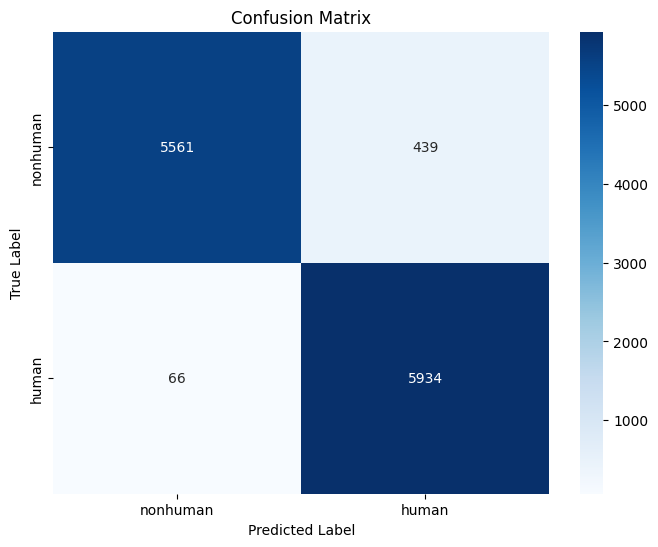

In [6]:
# ---  📊 Performance Metrics on Validation Set ---

# Get predictions using the validation loader
true_labels, predicted_labels = get_predictions(model_to_analyze, val_loader, device)

# Calculate and print overall accuracy as a percentage
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Overall Validation Accuracy: {accuracy * 100:.2f}%")
    
# Classification Report
print("\n--- Classification Report ---")
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)
    
# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()